In [1]:
#Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time

torch.manual_seed(0)

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5, padding=1, stride=2)
        self.pool=nn.MaxPool2d(2,2)

        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(16*1*1, 128)
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        #print(x.shape)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        #x=F.softmax(x, dim=1)
        return x

model=Network()

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [4]:
state_dict=torch.load('checkpoint.pth')
model.load_state_dict(state_dict)
print(model.load_state_dict(state_dict))

<All keys matched successfully>


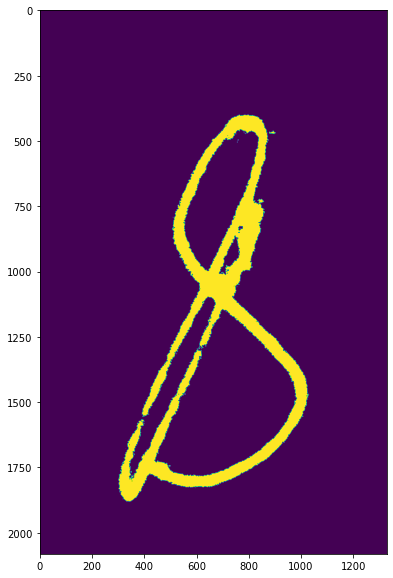

In [54]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('8.jpg')
rgb_img=img.copy()
rgb_img=cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
gray_img=rgb_img.copy()
gray_img=cv2.cvtColor(gray_img,cv2.COLOR_RGB2GRAY)
retval, threshold = cv2.threshold(gray_img, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#plt.imshow(threshold)
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
sorted_contours=sorted(contours, key=cv2.contourArea, reverse=True)
copy_img=rgb_img.copy()
drawing=cv2.drawContours(copy_img, sorted_contours[0], -1, (0,255,0),2)
x,y,w,h = cv2.boundingRect(sorted_contours[0])
x = x-300
y = y-400
w = w+600
h = h+600
copy=rgb_img.copy()
rect=cv2.rectangle(copy, (x,y), (x+w, y+h),(0,255,0), 2)
croped_img=threshold[y:y+h,x:x+w]
plt.figure(figsize=(15,10))
plt.imshow(croped_img)

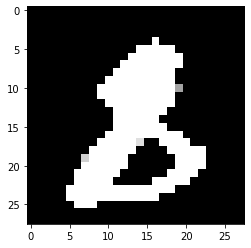

In [55]:

kernel=cv2.getStructuringElement(cv2.MORPH_CROSS, (15,15))
dst=cv2.dilate(croped_img, kernel, iterations=15)
dst=cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
dst=cv2.erode(dst, kernel, iterations=5)
dst=cv2.resize(dst, (28,28))
filename='output.png'
cv2.imwrite(filename, dst)
plt.imshow(dst, cmap='gray')

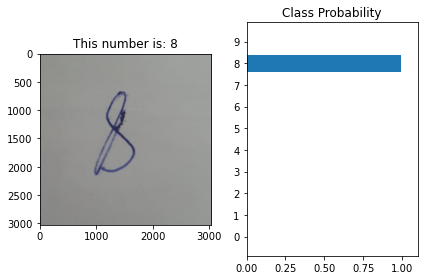

In [56]:
from PIL import Image
img_transformer=transforms.Compose([transforms.Grayscale(),transforms.Resize((28, 28)), 
                transforms.ToTensor(), 
                transforms.Normalize(mean=[(0.5)], std=[(0.5)])])

dst=Image.open('output.png')
input_tensor= img_transformer(dst)
input_batch=input_tensor.unsqueeze(0)
input_batch=input_batch.to(device)


output=model.forward(input_batch)
probability=F.softmax(output, dim=1)
pred=torch.argmax(probability, dim=1)
probability = probability.cpu().data.numpy().squeeze()

plt.subplot(1,2,1)
plt.title(f'This number is: {pred.item()}')
plt.imshow(rgb_img)
plt.subplot(1,2,2)
plt.barh(np.arange(10), probability)
plt.yticks(np.arange(10))
plt.title('Class Probability')
plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()